In [151]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import json
import geopandas as gpd
import folium
from shapely.geometry import Point
from statsmodels.formula.api import glm
import statsmodels.api as sm 
import numpy as np

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [152]:
endpoint = ('https://data.nashville.gov/resource/2u6v-ujjs.json?$limit=50000')
parameters = {
    '$where': 'incident_reported between "2021-01-01T00:00:00" and "2021-06-30T23:59:59"',
    'offense_description' : "BURGLARY- AGGRAVATED"
}
response = requests.get(endpoint, params = parameters)

In [153]:
burglaries = (pd.read_json(response.text)
            .drop_duplicates(subset = "incident_number"))

2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

In [154]:
census_tracts = gpd.read_file("./tl_2019_47_tract/tl_2019_47_tract.shp")

In [155]:
burglaries['geometry'] = burglaries.apply(lambda x: Point((x.longitude,   #creating geometry column
                                                       x.latitude)),
                                      axis=1)

geo_burglaries = gpd.GeoDataFrame(burglaries, 
                                crs = census_tracts.crs, 
                                geometry = burglaries['geometry'])

In [156]:
#clean up census_tracts and geo_burglaries before join

census_tracts = census_tracts[['COUNTYFP','NAMELSAD', 'TRACTCE', 'geometry']]
geo_burglaries = geo_burglaries[['incident_location','geometry']]

In [157]:
geo_burg_census = gpd.sjoin(geo_burglaries, census_tracts, op = 'within')

In [176]:
geo_burg_census.to_csv('geo_burg_census.csv', index = False)


In [158]:
geo_burg_census.NAMELSAD.mode() #Census Tract 163 had highest number of aggravated burglaries 

0    Census Tract 163
dtype: object

3. For this part, you'll need to request a census API key. Using the 2019 American Community Survey API, obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.

In [159]:
with open("./census.json") as fi:
    credentials = json.load(fi)
api_key = credentials["api_key"]


In [160]:
endpoint = 'https://api.census.gov/data/2019/acs/acs5/'
parameters = {
    'get': 'NAME,B01001_001E',
    'for':'tract:*',   #all tracts
    'in':'state:47 county:037' #TN and Davidson County 
}
  
response = requests.get(endpoint, params= parameters )

In [161]:
#Clean up dataframe by moving header up
davidson_pop = (pd.read_json(response.text))
header = davidson_pop.iloc[0]
davidson_pop = davidson_pop[1:]
davidson_pop.columns = header

In [162]:
endpoint = 'https://api.census.gov/data/2019/acs/acs5/subject'
parameters = {
    'get': 'NAME,S1901_C01_012E',
    'for':'tract:*',   #all tracts
    'in':'state:47 county:037' #TN and Davidson County 
}
  
response = requests.get(endpoint, params= parameters )

In [163]:
#Clean up dataframe by moving header up
davidson_inc = (pd.read_json(response.text))
header = davidson_inc.iloc[0]
davidson_inc = davidson_inc[1:]
davidson_inc.columns = header


In [164]:
census_data = pd.merge(davidson_pop, davidson_inc, how='inner')

In [165]:
census_data.rename(columns={'B01001_001E': 'Total_Population', 'tract':'TRACTCE', 'S1901_C01_012E':'Median_Income'}, inplace=True)

In [166]:
merged_geo_burg_census = pd.merge(geo_burg_census, census_data, how ="inner")

In [177]:
merged_geo_burg_census

,incident_location,geometry,index_right,COUNTYFP,NAMELSAD,TRACTCE,NAME,Total_Population,state,county,Median_Income
0,UNIVERSITY CT,POINT (-86.77000 36.15000),652,037,Census Tract 160,016000,"Census Tract 160, Davidson County, Tennessee",945,47,037,37083
1,LITTLE HAMILTON AVE,POINT (-86.76000 36.14000),652,037,Census Tract 160,016000,"Census Tract 160, Davidson County, Tennessee",945,47,037,37083
2,RAINS AVE,POINT (-86.76000 36.14000),652,037,Census Tract 160,016000,"Census Tract 160, Davidson County, Tennessee",945,47,037,37083
3,2ND AVE S,POINT (-86.77000 36.15000),652,037,Census Tract 160,016000,"Census Tract 160, Davidson County, Tennessee",945,47,037,37083
4,LEWIS ST,POINT (-86.76000 36.14000),652,037,Census Tract 160,016000,"Census Tract 160, Davidson County, Tennessee",945,47,037,37083
5,LEWIS ST,POINT (-86.76000 36.14000),652,037,Census Tract 160,016000,"Census Tract 160, Davidson County, Tennessee",945,47,037,37083
6,1ST AVE S,POINT (-86.77000 36.15000),652,037,Census Tract 160,016000,"Census Tract 160, Davidson County, Tennessee",945,47,037,37083
7,BONNAFAIR DR,POINT (-86.63000 36.20000),708,037,Census Tract 154.02,015402,"Census Tract 154.02, Davidson County, Tennessee",4717,47,037,69740
8,MEDALIST CIR,POINT (-86.64000 36.19000),708,037,Census Tract 154.02,015402,"Census Tract 154.02, Davidson County, Tennessee",4717,47,037,69740
9,BONNABROOK DR,POINT (-86.63000 36.20000),708,037,Census Tract 154.02,015402,"Census Tract 154.02, Davidson County, Tennessee",4717,47,037,69740


In [178]:
merged_geo_burg_census.to_csv('merged_geo_burg_census.csv', index = False)


4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [167]:
#Find nymber of aggravated burglaries per census tract
grouped_burg = (merged_geo_burg_census.groupby(['TRACTCE', 'Total_Population'])
                .size()
                .reset_index()
                .rename(columns={0:'Burglary_Number'})
)
grouped_burg

,TRACTCE,Total_Population,Burglary_Number
0,010104,2955,5
1,010105,4435,3
2,010106,3397,7
3,010201,4157,4
4,010202,3962,1
5,010301,3395,1
6,010303,5105,1
7,010401,5014,4
8,010402,6701,10
9,010501,5240,8


In [141]:
#Merge new dataframe to main and drop duplicates
merged_geo_burg_census = pd.merge(merged_geo_burg_census, grouped_burg).drop_duplicates(subset ="NAMELSAD",
                     keep = 'first')

In [143]:
#Clean up 
merged_geo_burg_census = merged_geo_burg_census[['geometry', 'NAMELSAD','Total_Population', 'Median_Income', 'Burglary_Number']]

In [144]:
# Use groupby to create new column, "Burglary_Number"
merged_geo_burg_census['Total_Population'] = merged_geo_burg_census['Total_Population'].astype(int)
merged_geo_burg_census['Median_Income'] = merged_geo_burg_census['Median_Income'].astype(int)

C:\Users\j0909\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [145]:
merged_geo_burg_census = merged_geo_burg_census[merged_geo_burg_census.Total_Population != 0]
merged_geo_burg_census.dtypes

geometry            geometry
NAMELSAD              object
Total_Population       int32
Median_Income          int32
Burglary_Number        int64
dtype: object

In [146]:
#Find number of burglaries per 1k residents for each tract, # Merge population, income, burglary data
merged_geo_burg_census['Burglaries_per_1000']= merged_geo_burg_census['Burglary_Number']/ merged_geo_burg_census['Total_Population']*1000

In [147]:
merged_burglaries_per_1000 = merged_geo_burg_census.dropna()

In [171]:
merged_burglaries_per_1000 = merged_burglaries_per_1000[merged_burglaries_per_1000.Total_Population != 0]

In [175]:
#merged_burglaries_per_1000.to_csv(r'C:\Users\j0909\Desktop\NSS\Projects')

merged_burglaries_per_1000.to_csv('burglaries.csv', index = False)

In [106]:
#Filter census for Davidson County: 037
census037 = census_tracts.loc[census_tracts['COUNTYFP'] == '037']   #why doesn't .isin work?

<AxesSubplot:>

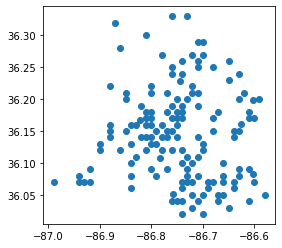

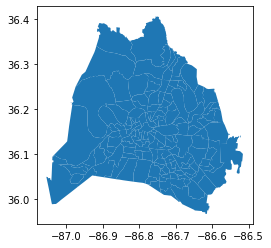

In [108]:
merged_burglaries_per_1000.plot()
census037.plot()

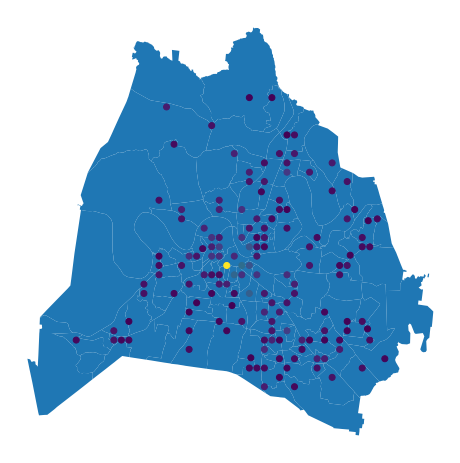

In [109]:
ax = census037.plot(figsize = (8,10))
merged_burglaries_per_1000.plot(column = 'Burglaries_per_1000',
                                ax = ax,
                                )
ax.axis('off');

In [110]:
census037.geometry.centroid

C:\Users\j0909\AppData\Local\Temp/ipykernel_16596/2557828512.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census037.geometry.centroid


27      POINT (-86.80361 36.25371)
36      POINT (-86.86754 36.34794)
37      POINT (-86.76775 36.34550)
38      POINT (-86.88435 36.29623)
63      POINT (-86.85305 36.15979)
64      POINT (-86.86787 36.12764)
97      POINT (-86.68176 36.25337)
98      POINT (-86.82852 36.17144)
122     POINT (-86.75202 36.17115)
123     POINT (-86.78168 36.15764)
124     POINT (-86.79011 36.17774)
127     POINT (-86.83004 36.13292)
128     POINT (-86.63912 36.09996)
129     POINT (-86.85388 36.24885)
130     POINT (-86.70321 36.30722)
178     POINT (-86.76079 36.20219)
179     POINT (-86.82680 36.10825)
184     POINT (-86.61504 36.06969)
273     POINT (-86.73378 36.19852)
284     POINT (-86.71704 36.24322)
285     POINT (-86.72275 36.27584)
409     POINT (-86.87151 36.15831)
410     POINT (-86.88362 36.15141)
411     POINT (-86.95784 36.07160)
412     POINT (-86.93826 36.07128)
413     POINT (-86.71502 36.13537)
415     POINT (-86.70238 36.13469)
416     POINT (-86.63711 36.05067)
429     POINT (-86.6

In [111]:
center = census037.geometry.centroid[27]

C:\Users\j0909\AppData\Local\Temp/ipykernel_16596/3260667071.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = census037.geometry.centroid[27]


In [112]:
print(center)

POINT (-86.80361436262164 36.25371488856963)


In [113]:
area_center = [center.y, center.x]

In [114]:
map_nashville = folium.Map(location=area_center)

In [115]:
folium.GeoJson(census037).add_to(map_nashville)


In [116]:
for row_index, row_values in stops_in_37207.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['route'])
    icon=folium.Icon(color="blue",icon="bus", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, icon = icon) 

    marker.add_to(map_37207)
map_37207.save('../maps/map37207.html')

#display our map
map_37207

NameError: name 'stops_in_37207' is not defined

5. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the Generalized Linear Models module of the statsmodels library.





#a. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.)

model = glm(formula, data, family

base_model.summary()
model_glm = glm(formula = 'Salary ~ Experience',
                data = salary,
                family = sm.families.Gaussian()).fit()


Poisson(link=sm.families.links.log

In [117]:
CHRIStable = gpd.read_file(r"C:\Users\j0909\Desktop\Dataset\merged_burglaries_per_1000.shp")

pd.options.display.max_rows=1000

CHRIStable

,INTPTLAT,INTPTLON,Census_Tra,Burglary_N,Total_Popu,Median_Inc,Burglaries,Log_Total_,Log_Median,Log_Burgla,Intercept,geometry
0,+36.2610013,-086.8023491,Census Tract 101.06,5,3397.0,63864.0,1.471887,8.130648,11.064511,-3.130648,1,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
1,+36.3619781,-086.7746355,Census Tract 102.02,1,3962.0,78750.0,0.252398,8.284504,11.274034,-7.284504,1,"POLYGON ((-86.82482 36.33225, -86.82480 36.332..."
2,+36.2918321,-086.8763469,Census Tract 101.04,4,2955.0,64844.0,1.353638,7.991254,11.079740,-3.991254,1,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
3,+36.1597942,-086.8530466,Census Tract 133,12,3997.0,69006.0,3.002252,8.293299,11.141949,3.706701,1,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."
4,+36.1276381,-086.8678660,Census Tract 181.02,2,3619.0,81724.0,0.552639,8.193953,11.311103,-6.193953,1,"POLYGON ((-86.88737 36.11771, -86.88733 36.117..."
5,+36.2533653,-086.6817552,Census Tract 106.02,6,4125.0,49242.0,1.454545,8.324821,10.804502,-2.324821,1,"POLYGON ((-86.69530 36.25263, -86.69513 36.253..."
6,+36.1711529,-086.7520191,Census Tract 192,4,3897.0,54837.0,1.026431,8.267962,10.912120,-4.267962,1,"POLYGON ((-86.76277 36.17259, -86.76250 36.172..."
7,+36.1572432,-086.7814636,Census Tract 195,18,7956.0,75446.0,2.262443,8.981682,11.231172,9.018318,1,"POLYGON ((-86.80272 36.15248, -86.80083 36.153..."
8,+36.1773911,-086.7901872,Census Tract 194,8,5810.0,81286.0,1.376936,8.667336,11.305729,-0.667336,1,"POLYGON ((-86.80102 36.17745, -86.80100 36.177..."
9,+36.1329172,-086.8300432,Census Tract 167,6,5304.0,113875.0,1.131222,8.576217,11.642857,-2.576217,1,"POLYGON ((-86.84760 36.13154, -86.84741 36.132..."


In [118]:
base_model = glm("Burglary_Number ~ np.log(Total_Population)",
                 data = merged_burglaries_per_1000, 
                 family = sm.families.Poisson()).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Burglary_Number   No. Observations:                  147
Model:                            GLM   Df Residuals:                      145
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -510.69
Date:                Sat, 09 Oct 2021   Deviance:                       537.24
Time:                        12:01:52   Pearson chi2:                     847.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01053
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.8341      0.715      1.166      0.244      -0.568       2.236
np.log(Total_Population)     0.1067      0.086      1.245      0.213      -0.061       0.275
============================================================================================
"""

In [119]:
merged_burglaries_per_1000['Median_Income'] = merged_burglaries_per_1000['Median_Income'].astype('int64')

In [120]:
poisson_model = glm("Burglary_Number ~ Median_Income", 
                 data = merged_burglaries_per_1000, 
                 offset = np.log(merged_burglaries_per_1000['Total_Population']),   
                 family = sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Burglary_Number   No. Observations:                  147
Model:                            GLM   Df Residuals:                      145
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -563.08
Date:                Sat, 09 Oct 2021   Deviance:                       642.03
Time:                        12:01:52   Pearson chi2:                 1.30e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.006192
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.6724      0.035   -191.319      0.000      -6.741      -6.604
Median_Income  1.232e-09   1.49e-09      0.826      0.409   -1.69e-09    4.16e-09
=================================================================================
"""

In [121]:
nb2_model = glm("Burglary_Number ~ Median_Income", 
                 data = merged_burglaries_per_1000, 
                 offset = np.log(merged_burglaries_per_1000['Total_Population']),   
                 family = sm.families.NegativeBinomial()).fit()

nb2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Burglary_Number   No. Observations:                  147
Model:                            GLM   Df Residuals:                      145
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -421.95
Date:                Sat, 09 Oct 2021   Deviance:                       95.606
Time:                        12:01:52   Pearson chi2:                     225.
No. Iterations:                     6   Pseudo R-squ. (CS):           0.003008
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.5408      0.090    -72.813      0.000      -6.717      -6.365
Median_Income  1.441e-09   2.12e-09      0.679      0.497   -2.72e-09     5.6e-09
=================================================================================
"""

In [122]:
#5d: How do your models compare? Hint: the fit models have an AIC attribute.
print(base_model.aic)
print(poisson_model.aic)
print(nb2_model.aic)

1025.3732258817313
1130.1629882527702
847.8903552801714
